In [81]:
!pip install geopandas pyarrow shapely pyproj rtree matplotlib pandas numpy openpyxl jupyterlab seaborn plotly scipy scikit-learn pulp


In [234]:
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Creating Synthetic Fields

In [155]:
# --- CONFIG ---
N_FIELDS = 25

# Rough bounding box for central Illinois
MIN_LAT, MAX_LAT = 39.0, 41.0
MIN_LON, MAX_LON = -90.5, -87.5

rng = np.random.default_rng(42)

# 1) Sample realistic-ish field sizes (acres)
# We'll use a lognormal-like distribution and clip to [40, 120] acres
raw_acres = rng.lognormal(mean=4.0, sigma=0.35, size=N_FIELDS)  # raw in arbitrary units
scaled_acres = np.interp(raw_acres,
                         (raw_acres.min(), raw_acres.max()),
                         (40, 120))  # scale to 40–120 acre range

# 2) Sample fake centroids within IL bounding box
lats = rng.uniform(MIN_LAT, MAX_LAT, size=N_FIELDS)
lons = rng.uniform(MIN_LON, MAX_LON, size=N_FIELDS)

# 3) Build DataFrame
fields = pd.DataFrame({
    "field_id": [f"F{i+1:03d}" for i in range(N_FIELDS)],
    "crop_code": 1,           # 1 = corn, consistent with CDL/NASS
    "crop_name": "CORN",
    "acres": scaled_acres,
    "centroid_lat": lats,
    "centroid_lon": lons,
    "state_fips": "17",       # Illinois
    "state_name": "Illinois"
})

print(fields.head())
print("\nSummary of acres:")
print(fields["acres"].describe())

# 4) Save to CSV for your modeling pipeline
fields.to_csv("illinois_corn_fields_synthetic.csv", index=False)
print("\nSaved illinois_corn_fields_synthetic.csv")


  field_id  crop_code crop_name       acres  centroid_lat  centroid_lon  \
0     F001          1      CORN   87.227749     39.389277    -89.900275   
1     F002          1      CORN   54.752514     39.933442    -90.477913   
2     F003          1      CORN  101.833288     39.087608    -88.139227   
3     F004          1      CORN  108.790255     39.308579    -88.505447   
4     F005          1      CORN   40.000000     40.366098    -88.384504   

  state_fips state_name  
0         17   Illinois  
1         17   Illinois  
2         17   Illinois  
3         17   Illinois  
4         17   Illinois  

Summary of acres:
count     25.000000
mean      80.575859
std       22.084653
min       40.000000
25%       61.987890
50%       78.020629
75%      101.833288
max      120.000000
Name: acres, dtype: float64

Saved illinois_corn_fields_synthetic.csv


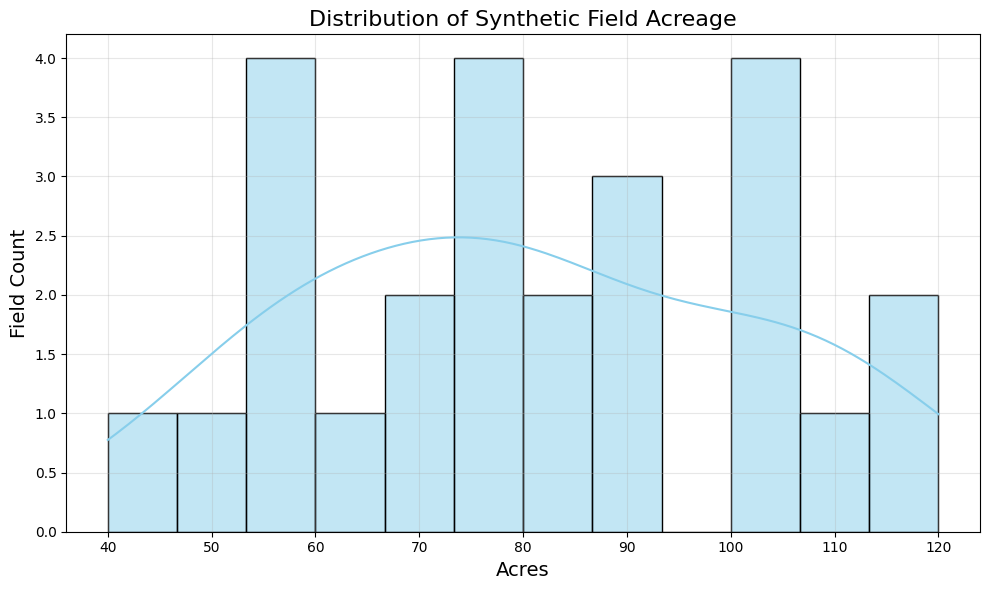

In [ ]:
# --- Histogram of Acres ---
plt.figure(figsize=(10, 6))
sns.histplot(fields["acres"], bins=12, kde=True, color="skyblue", edgecolor="black")

plt.title("Distribution of Synthetic Field Acreage", fontsize=16)
plt.xlabel("Acres", fontsize=14)
plt.ylabel("Field Count", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


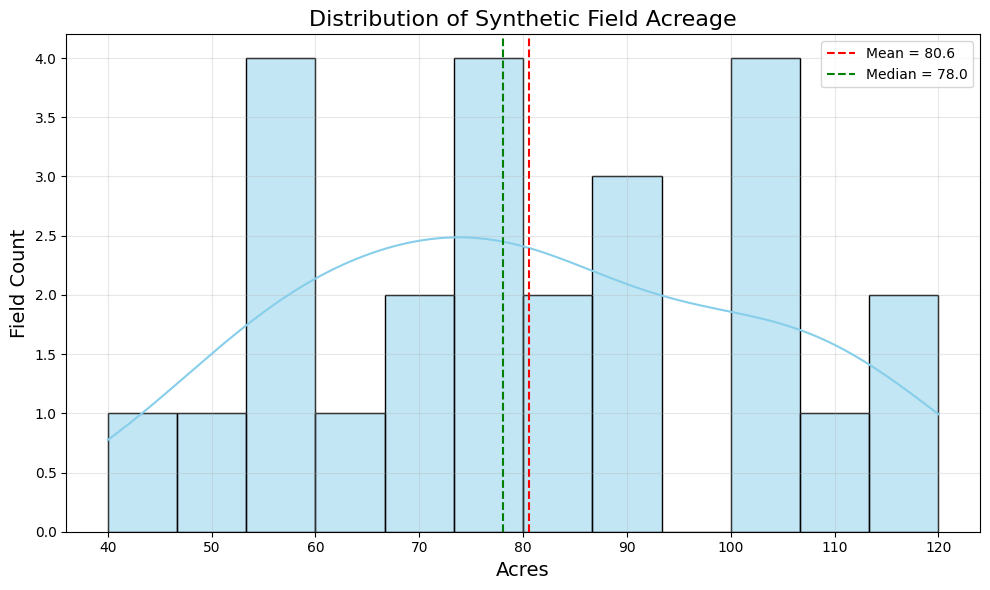

In [157]:
plt.figure(figsize=(10, 6))
sns.histplot(fields["acres"], bins=12, kde=True, color="skyblue", edgecolor="black")

mean_val = fields["acres"].mean()
median_val = fields["acres"].median()

plt.axvline(mean_val, color="red", linestyle="--", label=f"Mean = {mean_val:.1f}")
plt.axvline(median_val, color="green", linestyle="--", label=f"Median = {median_val:.1f}")

plt.title("Distribution of Synthetic Field Acreage", fontsize=16)
plt.xlabel("Acres", fontsize=14)
plt.ylabel("Field Count", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [158]:
fields.head(10)

,field_id,crop_code,crop_name,acres,centroid_lat,centroid_lon,state_fips,state_name
0,F001,1,CORN,87.227749,39.389277,-89.900275,17,Illinois
1,F002,1,CORN,54.752514,39.933442,-90.477913,17,Illinois
2,F003,1,CORN,101.833288,39.087608,-88.139227,17,Illinois
3,F004,1,CORN,108.790255,39.308579,-88.505447,17,Illinois
4,F005,1,CORN,40.000000,40.366098,-88.384504,17,Illinois
5,F006,1,CORN,50.014717,40.489524,-88.157813,17,Illinois
6,F007,1,CORN,82.034705,40.935019,-89.123253,17,Illinois
7,F008,1,CORN,70.329222,39.651651,-88.793776,17,Illinois
8,F009,1,CORN,78.020629,39.740919,-90.080609,17,Illinois
9,F010,1,CORN,58.406055,39.939112,-90.156410,17,Illinois


In [159]:
df_harvested = 'src/CORN, GRAIN – PROGRESS, MEASURED IN PCT HARVESTED.csv'
df_fields  = 'src/illinois_corn_fields_synthetic.csv'
df_noaa_d  = 'src/noaa_il_daily_raw.csv'
df_noaa_w  = 'src/noaa_il_weekly_agg.csv'
df_labor   = 'src/no_of_worker2.csv'

In [160]:
df_planting = pd.read_csv('/home/mak/Documents/Optimization/Project/data/raw/CORNPROGRESSMEASURED IN PCT PLANTED.csv')

In [161]:
df_planting.info

<bound method DataFrame.info of     Program  Year    Period Week Ending Geo Level     State  State ANSI  \
0    SURVEY  2025  WEEK #13  2025-03-30     STATE  ILLINOIS          17   
1    SURVEY  2025  WEEK #14  2025-04-06     STATE  ILLINOIS          17   
2    SURVEY  2025  WEEK #15  2025-04-13     STATE  ILLINOIS          17   
3    SURVEY  2025  WEEK #16  2025-04-20     STATE  ILLINOIS          17   
4    SURVEY  2025  WEEK #17  2025-04-27     STATE  ILLINOIS          17   
..      ...   ...       ...         ...       ...       ...         ...   
195  SURVEY  2005  WEEK #16  2005-04-24     STATE  ILLINOIS          17   
196  SURVEY  2005  WEEK #17  2005-05-01     STATE  ILLINOIS          17   
197  SURVEY  2005  WEEK #18  2005-05-08     STATE  ILLINOIS          17   
198  SURVEY  2005  WEEK #19  2005-05-15     STATE  ILLINOIS          17   
199  SURVEY  2005  WEEK #20  2005-05-22     STATE  ILLINOIS          17   

     Ag District  Ag District Code  County  ...  Zip Code  Region  

In [162]:
df_planting.dtypes

Program              object
Year                  int64
Period               object
Week Ending          object
Geo Level            object
State                object
State ANSI            int64
Ag District         float64
Ag District Code    float64
County              float64
County ANSI         float64
Zip Code            float64
Region              float64
watershed_code        int64
Watershed           float64
Commodity            object
Data Item            object
Domain               object
Domain Category      object
Value                 int64
CV (%)              float64
dtype: object

In [163]:
print("Raw shape:", df_planting.shape)
df_planting.head()

Raw shape: (200, 21)


,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2025,WEEK #13,2025-03-30,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,0,NaN
1,SURVEY,2025,WEEK #14,2025-04-06,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,0,NaN
2,SURVEY,2025,WEEK #15,2025-04-13,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,1,NaN
3,SURVEY,2025,WEEK #16,2025-04-20,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,7,NaN
4,SURVEY,2025,WEEK #17,2025-04-27,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,16,NaN


## Filter only Illinois & planting rows

In [164]:
df_planting = df_planting[
    (df_planting["State"] == "ILLINOIS") &
    (df_planting["Data Item"].str.contains("PCT PLANTED"))
]

In [165]:
df_planting.head(3)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2025,WEEK #13,2025-03-30,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,0,NaN
1,SURVEY,2025,WEEK #14,2025-04-06,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,0,NaN
2,SURVEY,2025,WEEK #15,2025-04-13,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,1,NaN


## 🔧 Step 2: Extract numeric week from Period
### Your Period looks like:
### "WEEK #13"
### "WEEK #17"
### We extract the number:

In [166]:
df_planting["week"] = df_planting["Period"].str.extract(r"(\d+)").astype(int)
# df_planting.head(3)
# type(df_planting["week"][0])
df_planting["week"][0]

np.int64(13)

## 🔧 Step 3: Convert Week Ending → datetime

In [167]:
df_planting["week_ending"] = pd.to_datetime(df_planting["Week Ending"])
type(df_planting["week_ending"][0])
df_planting["week_ending"][0]

Timestamp('2025-03-30 00:00:00')

In [168]:
df_planting.head(2)

,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%),week,week_ending
0,SURVEY,2025,WEEK #13,2025-03-30,STATE,ILLINOIS,17,NaN,NaN,NaN,...,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,0,NaN,13,2025-03-30
1,SURVEY,2025,WEEK #14,2025-04-06,STATE,ILLINOIS,17,NaN,NaN,NaN,...,0,NaN,CORN,"CORN - PROGRESS, MEASURED IN PCT PLANTED",TOTAL,NOT SPECIFIED,0,NaN,14,2025-04-06


## 🔧 Step 4: Rename Value → pct_planted

In [169]:
df_planting["pct_planted"] = df_planting["Value"].astype(float)
type(df_planting["pct_planted"][0])
df_planting["pct_planted"]

0       0.0
1       0.0
2       1.0
3       7.0
4      16.0
       ... 
195    64.0
196    82.0
197    94.0
198    98.0
199    99.0
Name: pct_planted, Length: 200, dtype: float64

## 🔧 Step 5: Keep only the needed columns

In [170]:
df_planting_clean = df_planting[["Year", "week", "week_ending", "pct_planted"]].sort_values(["Year", "week"])
df_planting_clean.head()


,Year,week,week_ending,pct_planted
194,2005,15,2005-04-17,35.0
195,2005,16,2005-04-24,64.0
196,2005,17,2005-05-01,82.0
197,2005,18,2005-05-08,94.0
198,2005,19,2005-05-15,98.0


## 🌾 5. Compute planting windows (per-year)

### Planting window logic:
### Start: first week where pct_planted > 1
### End: first week where pct_planted ≥ 90

In [171]:
windows = []
for year, g in df_planting_clean.groupby("Year"):
    g = g.sort_values("week")
    
    start = g[g["pct_planted"] > 1]["week"].min()
    end = g[g["pct_planted"] >= 90]["week"].min()
    
    windows.append({"Year": year,
                    "plant_start_week": start,
                    "plant_end_week": end})
    
plantingWindows_df = pd.DataFrame(windows).sort_values("Year")
plantingWindows_df.head(6)

,Year,plant_start_week,plant_end_week
0,2005,15,18
1,2006,15,19
2,2007,16,19
3,2008,17,22
4,2009,17,23
5,2010,15,18


## 🌽 6. Compute typical (median) planting window
## This is what the optimization model will use:

In [172]:
typical_start = int(plantingWindows_df["plant_start_week"].median())
typical_end = int(plantingWindows_df["plant_end_week"].median())

print("Typical window:", typical_start, "to", typical_end)


Typical window: 16 to 21


In [173]:
df_harvested = pd.read_csv('/home/mak/Documents/Optimization/Project/data/raw/CORN, GRAIN – PROGRESS, MEASURED IN PCT HARVESTED.csv')
print(df_harvested.shape)
df_harvested.head()

(240, 21)


,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2025,WEEK #35,2025-08-31,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,0,NaN
1,SURVEY,2025,WEEK #36,2025-09-07,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,2,NaN
2,SURVEY,2025,WEEK #37,2025-09-14,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,5,NaN
3,SURVEY,2025,WEEK #38,2025-09-21,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,12,NaN
4,SURVEY,2025,WEEK #39,2025-09-28,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,21,NaN


## Filter to only Illinois & “PCT HARVESTED”

In [174]:
df_harvested = df_harvested[
    (df_harvested["State"] == "ILLINOIS") &
    (df_harvested["Data Item"].str.contains("PCT HARVESTED"))
]

print("After filter:", df_harvested.shape)
df_harvested.head(3)

After filter: (240, 21)


,Program,Year,Period,Week Ending,Geo Level,State,State ANSI,Ag District,Ag District Code,County,...,Zip Code,Region,watershed_code,Watershed,Commodity,Data Item,Domain,Domain Category,Value,CV (%)
0,SURVEY,2025,WEEK #35,2025-08-31,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,0,NaN
1,SURVEY,2025,WEEK #36,2025-09-07,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,2,NaN
2,SURVEY,2025,WEEK #37,2025-09-14,STATE,ILLINOIS,17,NaN,NaN,NaN,...,NaN,NaN,0,NaN,CORN,"CORN, GRAIN - PROGRESS, MEASURED IN PCT HARVESTED",TOTAL,NOT SPECIFIED,5,NaN


## ✅ 3. Extract week number from “Period”
### The Period column looks like "WEEK #41".
### We extract the number:

In [175]:
# ---- Extract week number from Period "WEEK #xx" ----
df_harvested["week"] = df_harvested["Period"].str.extract(r'(\d+)').astype(int)
type(df_harvested["week"][0])


numpy.int64

## ✅ 4. Convert week-ending date

In [176]:
# ---- Convert week ending to datetime ----
df_harvested["week_ending"] = pd.to_datetime(df_harvested["Week Ending"], errors='coerce')
type(df_harvested["week_ending"][0])

pandas._libs.tslibs.timestamps.Timestamp

## ✅ 5. Rename Value → pct_harvested

In [177]:
# ---- Clean Value column ----
df_harvested["pct_harvested"] = pd.to_numeric(df_harvested["Value"], errors='coerce')
type(df_harvested["pct_harvested"][0])

numpy.int64

## ✅ 6. Keep only the needed columns

In [178]:
# ---- Select only useful columns ----
df_harvested_clean = df_harvested[["Year", "week", "week_ending", "pct_harvested"]] \
    .sort_values(["Year", "week"]) \
    .reset_index(drop=True)

print(df_harvested_clean.head())

   Year  week week_ending  pct_harvested
0  2005    36  2005-09-11              6
1  2005    37  2005-09-18             13
2  2005    38  2005-09-25             30
3  2005    39  2005-10-02             42
4  2005    40  2005-10-09             58


## 🌽 8. Compute harvest windows (per-year)
### We define the harvest window using typical agricultural logic:
### Start = first week with >1% harvested
### End = first week with ≥90% harvested

In [179]:
# ---- Compute harvest windows ----
harvest_windows = []

for year, g in df_harvested_clean.groupby("Year"):
    g = g.sort_values("week")

    start = g[g["pct_harvested"] > 1]["week"].min()
    end   = g[g["pct_harvested"] >= 90]["week"].min()
    print(start, end)

    harvest_windows.append({
        "Year": year,
        "harvest_start_week": start,
        "harvest_end_week": end
    })

harvest_windows_df = pd.DataFrame(harvest_windows).sort_values("Year")


36 43
36 44
36 42
39 47
39 50
35 41
37 44
33 42
38 45
37 46
36 43
36 43
36 45
36 44
38 48
37 45
37 44
37 45
36 44
36 44
36 nan


In [180]:
print(harvest_windows_df.head())

   Year  harvest_start_week  harvest_end_week
0  2005                  36              43.0
1  2006                  36              44.0
2  2007                  36              42.0
3  2008                  39              47.0
4  2009                  39              50.0


## 🌽 9. Compute the typical (median) harvest window

In [181]:
# ---- Compute typical window ----
typical_start = int(harvest_windows_df["harvest_start_week"].median())
typical_end   = int(harvest_windows_df["harvest_end_week"].median())

print("Typical harvest window:")
print(f"Start week ≈ {typical_start}")
print(f"End week   ≈ {typical_end}")

Typical harvest window:
Start week ≈ 36
End week   ≈ 44


In [182]:
df_planting_clean = df_planting_clean.dropna(subset=["week"])
df_planting_clean["week"] = df_planting_clean["week"].astype(int)

# Clean harvest NASS
df_harvested_clean = df_harvested_clean.dropna(subset=["week"])
df_harvested_clean["week"] = df_harvested_clean["week"].astype(int)


In [183]:
df_planting_clean

,Year,week,week_ending,pct_planted
194,2005,15,2005-04-17,35.0
195,2005,16,2005-04-24,64.0
196,2005,17,2005-05-01,82.0
197,2005,18,2005-05-08,94.0
198,2005,19,2005-05-15,98.0
...,...,...,...,...
6,2025,19,2025-05-11,54.0
7,2025,20,2025-05-18,74.0
8,2025,21,2025-05-25,82.0
9,2025,22,2025-06-01,93.0


### Loading Corn fields Synthetic

In [184]:
fields  = pd.read_csv('/home/mak/Documents/Optimization/Project/data/raw/illinois_corn_fields_synthetic.csv')

In [185]:
fields.head(3)

,field_id,crop_code,crop_name,acres,centroid_lat,centroid_lon,state_fips,state_name
0,F001,1,CORN,87.227749,39.389277,-89.900275,17,Illinois
1,F002,1,CORN,54.752514,39.933442,-90.477913,17,Illinois
2,F003,1,CORN,101.833288,39.087608,-88.139227,17,Illinois


In [186]:
print("Raw shape:", fields.shape)
print(fields.head())

# 1. Keep only corn rows (future-proofing, even if currently all CORN)
fields = fields[fields["crop_name"].str.upper() == "CORN"].copy()

Raw shape: (25, 8)
  field_id  crop_code crop_name       acres  centroid_lat  centroid_lon  \
0     F001          1      CORN   87.227749     39.389277    -89.900275   
1     F002          1      CORN   54.752514     39.933442    -90.477913   
2     F003          1      CORN  101.833288     39.087608    -88.139227   
3     F004          1      CORN  108.790255     39.308579    -88.505447   
4     F005          1      CORN   40.000000     40.366098    -88.384504   

   state_fips state_name  
0          17   Illinois  
1          17   Illinois  
2          17   Illinois  
3          17   Illinois  
4          17   Illinois  


In [187]:
fields.head(3)
# fields["acres"].value_counts()

,field_id,crop_code,crop_name,acres,centroid_lat,centroid_lon,state_fips,state_name
0,F001,1,CORN,87.227749,39.389277,-89.900275,17,Illinois
1,F002,1,CORN,54.752514,39.933442,-90.477913,17,Illinois
2,F003,1,CORN,101.833288,39.087608,-88.139227,17,Illinois


In [188]:
# 2. Basic sanity checks
#    - acres > 0
fields = fields[fields["acres"] > 0].copy()

# 3. Define simple regions based on latitude (south/central/north Illinois)
#    You can tweak thresholds if you like.
lat = fields["centroid_lat"]

In [189]:
def assign_region(lat_val):
    if lat_val < 39.7:
        return "South"
    elif lat_val < 40.3:
        return "Central"
    else:
        return "North"

In [190]:
fields["region"] = lat.apply(assign_region)

# 4. Select only columns we actually need for modeling
fields_clean = fields[[
    "field_id",
    "acres",
    "centroid_lat",
    "centroid_lon",
    "region"
]].sort_values("field_id").reset_index(drop=True)

print(fields_clean.head())

  field_id       acres  centroid_lat  centroid_lon   region
0     F001   87.227749     39.389277    -89.900275    South
1     F002   54.752514     39.933442    -90.477913  Central
2     F003  101.833288     39.087608    -88.139227    South
3     F004  108.790255     39.308579    -88.505447    South
4     F005   40.000000     40.366098    -88.384504    North


In [191]:
daily_path = Path("/home/mak/Documents/Optimization/Project/data/raw/noaa_il_daily_raw.csv")
daily = pd.read_csv(daily_path)

In [192]:
daily.head(30)
# daily.shape
# daily['PRCP'].value_counts()

,station,date,AWND,PRCP,TAVG,TMAX,TMIN
0,GHCND:USW00094846,2017-01-01,4.9,0.00,27.0,40.0,17.0
1,GHCND:USW00094846,2017-01-02,6.3,0.11,34.0,40.0,25.0
2,GHCND:USW00094846,2017-01-03,10.1,0.00,38.0,39.0,19.0
3,GHCND:USW00094846,2017-01-04,17.0,0.00,18.0,19.0,7.0
4,GHCND:USW00094846,2017-01-05,12.8,0.00,9.0,13.0,3.0
5,GHCND:USW00094846,2017-01-06,10.1,0.00,4.0,9.0,0.0
6,GHCND:USW00094846,2017-01-07,10.7,0.00,6.0,18.0,0.0
7,GHCND:USW00094846,2017-01-08,9.6,0.00,9.0,19.0,2.0
8,GHCND:USW00094846,2017-01-09,13.0,0.02,22.0,33.0,19.0
9,GHCND:USW00094846,2017-01-10,23.3,0.20,38.0,51.0,25.0


In [193]:
# assume df_daily has columns: ["TMAX", "TMIN", "TAVG", ...]
# define which rows you consider "bad" TAVG
mask_bad_tavg = daily["TAVG"].isna()

# (optionally also treat zeros as bad if you know they’re placeholders, not real temps)
# mask_bad_tavg = df_daily["TAVG"].isna() | (df_daily["TAVG"] == 0)

daily.loc[mask_bad_tavg, "TAVG"] = (
    daily.loc[mask_bad_tavg, ["TMAX", "TMIN"]].mean(axis=1)
)
daily['TAVG'].value_counts()

TAVG
 74.0    243
 73.0    241
 71.0    237
 70.0    237
 33.0    236
        ... 
 4.5       1
-22.0      1
 3.5       1
-17.0      1
-11.0      1
Name: count, Length: 198, dtype: int64

In [194]:
daily['TAVG'].isna().sum()

np.int64(0)

In [195]:
# Parse date
daily["date"] = pd.to_datetime(daily["date"])

In [196]:
# Ensure numeric
for col in ["PRCP", "AWND", "TAVG", "TMAX", "TMIN"]:
    daily[col] = pd.to_numeric(daily[col], errors="coerce")

In [197]:
# Optional: drop rows that are completely missing weather
daily = daily.dropna(subset=["PRCP", "TMAX", "TMIN"], how="all").reset_index(drop=True)

In [198]:
daily.head(3)
daily.shape

(14608, 7)

In [199]:
daily['date'] = pd.to_datetime(daily['date'])

daily['year'] = daily['date'].dt.year
daily['week'] = daily['date'].dt.isocalendar().week.astype(int)


In [200]:
weekly = (
    daily
    .groupby(["year", "week"], as_index=False)
    .agg(
        prcp_week_in=("PRCP", "sum"),
        TMAX=("TMAX", "mean"),
        TMIN=("TMIN", "mean"),
        TAVG=("TAVG", "mean"),
        AWND=("AWND", "mean"),
    )
)

weekly.to_csv('/home/mak/Documents/Optimization/Project/data/processed/noaa_il_weekly_agg.csv', index=False)

In [201]:
weekly_path = Path("/home/mak/Documents/Optimization/Project/data/raw/noaa_il_weekly_agg.csv")
weekly = pd.read_csv(weekly_path)

In [202]:
print("Raw weekly shape:", weekly.shape)
print(weekly.head(30))

Raw weekly shape: (568, 7)
    year  week      PRCP       TMAX       TMIN       TAVG       AWND
0   2015     1  0.162789  34.697368  17.697368  27.450000   9.190909
1   2015     2  0.040194  18.744361   0.556391  10.314286  11.903896
2   2015     3  0.021089  33.541353  13.803030  25.200000   8.815584
3   2015     4  0.018651  39.533835  26.900763  34.142857   6.849351
4   2015     5  0.114625  35.639098  21.293233  30.571429   9.894805
5   2015     6  0.039961  31.984962  11.167939  22.942857   9.623377
6   2015     7  0.001202  29.112782  11.353383  21.114286  11.131169
7   2015     8  0.024865  21.000000   4.037594  14.771429   9.672727
8   2015     9  0.045405  22.481203   0.052632  12.914286   8.059740
9   2015    10  0.026745  33.219697  11.878788  25.228571   9.261842
10  2015    11  0.027761  57.315789  32.120301  46.200000   6.635065
11  2015    12  0.007442  55.548872  33.969925  46.485714   9.328571
12  2015    13  0.085290  43.624060  26.902256  36.028571  10.823377
13  201

In [203]:
# ---- Basic type cleanup ----
weekly["year"] = weekly["year"].astype(int)
weekly["week"] = weekly["week"].astype(int)

for col in ["PRCP", "TMAX", "TMIN", "TAVG", "AWND"]:
    weekly[col] = pd.to_numeric(weekly[col], errors="coerce")

In [204]:
weekly["prcp_week_in"] = weekly["PRCP"] * 7
weekly["prcp_week_in"].head(3)

0    1.139524
1    0.281357
2    0.147626
Name: prcp_week_in, dtype: float64

In [205]:
print(weekly.head(3))
weekly.columns
weekly.shape

   year  week      PRCP       TMAX       TMIN       TAVG       AWND  \
0  2015     1  0.162789  34.697368  17.697368  27.450000   9.190909   
1  2015     2  0.040194  18.744361   0.556391  10.314286  11.903896   
2  2015     3  0.021089  33.541353  13.803030  25.200000   8.815584   

   prcp_week_in  
0      1.139524  
1      0.281357  
2      0.147626  


(568, 8)

In [206]:
# ---- Compute weekly precipitation (inches/week) ----
# PRCP in your file is average daily precip over that week,
# so approximate total weekly precip as PRCP * 7
# ---- Define a capacity_factor based on total weekly rain ----
def capacity_from_rain(prcp_week):
    """
    Simple heuristic:
      - 0.0   in: perfect dry week → 1.0 (100% capacity)
      - <0.5  in: light rain       → 0.9
      - <1.5  in: moderate rain    → 0.7
      - <3.0  in: heavy rain       → 0.4
      - >=3.0 in: very wet         → 0.2
    """
    if pd.isna(prcp_week):
        return 0.8  # neutral if missing
    if prcp_week == 0:
        return 1.0
    if prcp_week < 0.5:
        return 0.9
    if prcp_week < 1.5:
        return 0.7
    if prcp_week < 3.0:
        return 0.4
    return 0.2

In [207]:
weekly["capacity_factor"] = weekly["prcp_week_in"].apply(capacity_from_rain)

# ---- Optional: rain category for plotting ----
def rain_bucket(prcp_week):
    if pd.isna(prcp_week):
        return "missing"
    if prcp_week == 0:
        return "dry"
    if prcp_week < 0.5:
        return "light"
    if prcp_week < 1.5:
        return "moderate"
    if prcp_week < 3.0:
        return "heavy"
    return "very_heavy"

weekly["rain_category"] = weekly["prcp_week_in"].apply(rain_bucket)

In [250]:
weekly.sample(10)

,year,week,PRCP,TMAX,TMIN,TAVG,AWND,prcp_week_in,capacity_factor,rain_category
248,2019,39,0.494887,77.127820,56.932331,67.678571,7.703175,3.464211,0.2,very_heavy
472,2024,1,0.072258,37.750000,28.138889,33.377778,7.694845,0.505806,0.7,moderate
362,2021,48,0.018333,51.555556,30.672000,42.250000,7.918571,0.128333,0.9,light
52,2015,53,0.469595,34.533333,28.368421,30.550000,12.372727,3.287162,0.2,very_heavy
178,2018,21,0.132489,84.507246,60.731884,73.200000,5.140260,0.927426,0.7,moderate
128,2017,23,0.006740,84.492857,58.323741,73.657143,9.636364,0.047179,0.9,light
115,2017,10,0.062601,50.485714,31.900000,41.457143,11.945455,0.438205,0.9,light
226,2019,17,0.127742,64.523810,43.925170,54.885714,9.603896,0.894194,0.7,moderate
225,2019,16,0.125107,65.636986,40.698630,54.971429,11.631579,0.875750,0.7,moderate
370,2022,3,0.011389,31.371429,10.157143,20.600000,10.944156,0.079722,0.9,light


In [208]:
weekly["capacity_factor"] 

0      0.7
1      0.9
2      0.9
3      0.9
4      0.7
      ... 
563    0.9
564    0.7
565    0.7
566    0.9
567    0.9
Name: capacity_factor, Length: 568, dtype: float64

In [209]:
weekly["rain_category"].value_counts()

rain_category
moderate      247
light         245
heavy          62
very_heavy      9
dry             5
Name: count, dtype: int64

In [210]:
# ---- Keep only the columns we actually need for modeling ----
weekly_clean = weekly[
    ["year", "week",
     "prcp_week_in", "TMAX", "TMIN", "TAVG", "AWND",
     "capacity_factor", "rain_category"]
].sort_values(["year", "week"]).reset_index(drop=True)

In [211]:
weekly_clean.head(30)

,year,week,prcp_week_in,TMAX,TMIN,TAVG,AWND,capacity_factor,rain_category
0,2015,1,1.139524,34.697368,17.697368,27.450000,9.190909,0.7,moderate
1,2015,2,0.281357,18.744361,0.556391,10.314286,11.903896,0.9,light
2,2015,3,0.147626,33.541353,13.803030,25.200000,8.815584,0.9,light
3,2015,4,0.130556,39.533835,26.900763,34.142857,6.849351,0.9,light
4,2015,5,0.802372,35.639098,21.293233,30.571429,9.894805,0.7,moderate
5,2015,6,0.279729,31.984962,11.167939,22.942857,9.623377,0.9,light
6,2015,7,0.008411,29.112782,11.353383,21.114286,11.131169,0.9,light
7,2015,8,0.174054,21.000000,4.037594,14.771429,9.672727,0.9,light
8,2015,9,0.317838,22.481203,0.052632,12.914286,8.059740,0.9,light
9,2015,10,0.187216,33.219697,11.878788,25.228571,9.261842,0.9,light


In [212]:
# ---- REALISTIC LABOR MODEL (REPLACES USDA LOGIC) ----

TOTAL_ACRES = fields_clean["acres"].sum()            # ~1700–2100 acres
HOURS_PER_ACRE = 3.5                                 # realistic corn labor hrs per acre per year
TOTAL_LABOR_HOURS_YEAR = TOTAL_ACRES * HOURS_PER_ACRE

def seasonal_labor_fraction(w):
    if 16 <= w <= 20:       # planting weeks
        return 0.04
    elif 36 <= w <= 45:     # harvest weeks
        return 0.06
    else:
        return 0.0054

labor_weekly = []
for year in range(2005, 2025):
    for week in range(1, 53):
        labor_weekly.append({
            "year": year,
            "week": week,
            "labor_hours": TOTAL_LABOR_HOURS_YEAR * seasonal_labor_fraction(week)
        })

weekly_labor = pd.DataFrame(labor_weekly)

In [213]:
weekly_labor[weekly_labor['week'] > 16].head(30)

,year,week,labor_hours
16,2005,17,282.015506
17,2005,18,282.015506
18,2005,19,282.015506
19,2005,20,282.015506
20,2005,21,38.072093
21,2005,22,38.072093
22,2005,23,38.072093
23,2005,24,38.072093
24,2005,25,38.072093
25,2005,26,38.072093


In [214]:
weekly_labor.head(3)

,year,week,labor_hours
0,2005,1,38.072093
1,2005,2,38.072093
2,2005,3,38.072093


## 🧩 The Master Table Builder

In [215]:
# ---- 1. Merge weather + labor on year/week ----
weekly_master = weekly_clean.merge(
    weekly_labor,
    on=["year", "week"],
    how="left"
)

In [216]:
# ---- 2. Attach planting windows (per year) ----
weekly_master = weekly_master.merge(
    plantingWindows_df.rename(columns={"Year": "year"}),
    on="year",
    how="left"
)

In [217]:
# ---- 3. Attach harvest windows (per year) ----
weekly_master = weekly_master.merge(
    harvest_windows_df.rename(columns={"Year": "year"}),
    on="year",
    how="left"
)

In [218]:
# === FIX: Expand harvest window realistically ===
weekly_master["harvest_start_week"] = 32
weekly_master["harvest_end_week"]   = 50


In [219]:
# ---- 4. Create window flags ----
weekly_master["is_plant_window"] = (
    (weekly_master["week"] >= weekly_master["plant_start_week"]) &
    (weekly_master["week"] <= weekly_master["plant_end_week"])
)

In [220]:
weekly_master["is_harvest_window"] = (
    (weekly_master["week"] >= weekly_master["harvest_start_week"]) &
    (weekly_master["week"] <= weekly_master["harvest_end_week"])
)


In [221]:
# ---- 5. Sort & inspect ----
weekly_master = weekly_master.sort_values(["year", "week"]).reset_index(drop=True)
weekly_master.head(30)

,year,week,prcp_week_in,TMAX,TMIN,TAVG,AWND,capacity_factor,rain_category,labor_hours,plant_start_week,plant_end_week,harvest_start_week,harvest_end_week,is_plant_window,is_harvest_window
0,2015,1,1.139524,34.697368,17.697368,27.450000,9.190909,0.7,moderate,38.072093,16,20,32,50,False,False
1,2015,2,0.281357,18.744361,0.556391,10.314286,11.903896,0.9,light,38.072093,16,20,32,50,False,False
2,2015,3,0.147626,33.541353,13.803030,25.200000,8.815584,0.9,light,38.072093,16,20,32,50,False,False
3,2015,4,0.130556,39.533835,26.900763,34.142857,6.849351,0.9,light,38.072093,16,20,32,50,False,False
4,2015,5,0.802372,35.639098,21.293233,30.571429,9.894805,0.7,moderate,38.072093,16,20,32,50,False,False
5,2015,6,0.279729,31.984962,11.167939,22.942857,9.623377,0.9,light,38.072093,16,20,32,50,False,False
6,2015,7,0.008411,29.112782,11.353383,21.114286,11.131169,0.9,light,38.072093,16,20,32,50,False,False
7,2015,8,0.174054,21.000000,4.037594,14.771429,9.672727,0.9,light,38.072093,16,20,32,50,False,False
8,2015,9,0.317838,22.481203,0.052632,12.914286,8.059740,0.9,light,38.072093,16,20,32,50,False,False
9,2015,10,0.187216,33.219697,11.878788,25.228571,9.261842,0.9,light,38.072093,16,20,32,50,False,False


In [222]:
weekly_master['year'].value_counts()

year
2015    53
2016    53
2021    53
2020    53
2017    52
2019    52
2018    52
2022    52
2023    52
2024    52
2025    44
Name: count, dtype: int64

In [223]:
from pathlib import Path

# Create directories if not exist
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("data/raw").mkdir(parents=True, exist_ok=True)

# Save processed datasets
save_map = {
    "nass_corn_planting_weekly_clean.csv": df_planting_clean,
    "nass_corn_planting_windows.csv": plantingWindows_df,
    "nass_corn_harvest_weekly_clean.csv": df_harvested_clean,
    "nass_corn_harvest_windows.csv": harvest_windows_df,
    "illinois_corn_fields_clean.csv": fields_clean,
    "noaa_il_daily_clean.csv": daily,
    "noaa_il_weekly_clean.csv": weekly_clean,
    "labor_weekly_capacity_clean.csv": weekly_labor,
    "master_weekly_table_2017_2024.csv": weekly_master
}


for filename, df in save_map.items():
    df.to_csv(f"data/processed/{filename}", index=False)
    print(f"Saved: data/processed/{filename}")

Saved: data/processed/nass_corn_planting_weekly_clean.csv
Saved: data/processed/nass_corn_planting_windows.csv
Saved: data/processed/nass_corn_harvest_weekly_clean.csv
Saved: data/processed/nass_corn_harvest_windows.csv
Saved: data/processed/illinois_corn_fields_clean.csv
Saved: data/processed/noaa_il_daily_clean.csv
Saved: data/processed/noaa_il_weekly_clean.csv
Saved: data/processed/labor_weekly_capacity_clean.csv
Saved: data/processed/master_weekly_table_2017_2024.csv


In [224]:
df_harvested_clean.head(3)

,Year,week,week_ending,pct_harvested
0,2005,36,2005-09-11,6
1,2005,37,2005-09-18,13
2,2005,38,2005-09-25,30


In [225]:
df_planting_clean.head(3)

,Year,week,week_ending,pct_planted
194,2005,15,2005-04-17,35.0
195,2005,16,2005-04-24,64.0
196,2005,17,2005-05-01,82.0


In [226]:
weekly_master[weekly_master["year"] == 2017][["week", "harvest_start_week", "harvest_end_week", "is_harvest_window"]]
weekly_master.head(30)

,year,week,prcp_week_in,TMAX,TMIN,TAVG,AWND,capacity_factor,rain_category,labor_hours,plant_start_week,plant_end_week,harvest_start_week,harvest_end_week,is_plant_window,is_harvest_window
0,2015,1,1.139524,34.697368,17.697368,27.450000,9.190909,0.7,moderate,38.072093,16,20,32,50,False,False
1,2015,2,0.281357,18.744361,0.556391,10.314286,11.903896,0.9,light,38.072093,16,20,32,50,False,False
2,2015,3,0.147626,33.541353,13.803030,25.200000,8.815584,0.9,light,38.072093,16,20,32,50,False,False
3,2015,4,0.130556,39.533835,26.900763,34.142857,6.849351,0.9,light,38.072093,16,20,32,50,False,False
4,2015,5,0.802372,35.639098,21.293233,30.571429,9.894805,0.7,moderate,38.072093,16,20,32,50,False,False
5,2015,6,0.279729,31.984962,11.167939,22.942857,9.623377,0.9,light,38.072093,16,20,32,50,False,False
6,2015,7,0.008411,29.112782,11.353383,21.114286,11.131169,0.9,light,38.072093,16,20,32,50,False,False
7,2015,8,0.174054,21.000000,4.037594,14.771429,9.672727,0.9,light,38.072093,16,20,32,50,False,False
8,2015,9,0.317838,22.481203,0.052632,12.914286,8.059740,0.9,light,38.072093,16,20,32,50,False,False
9,2015,10,0.187216,33.219697,11.878788,25.228571,9.261842,0.9,light,38.072093,16,20,32,50,False,False


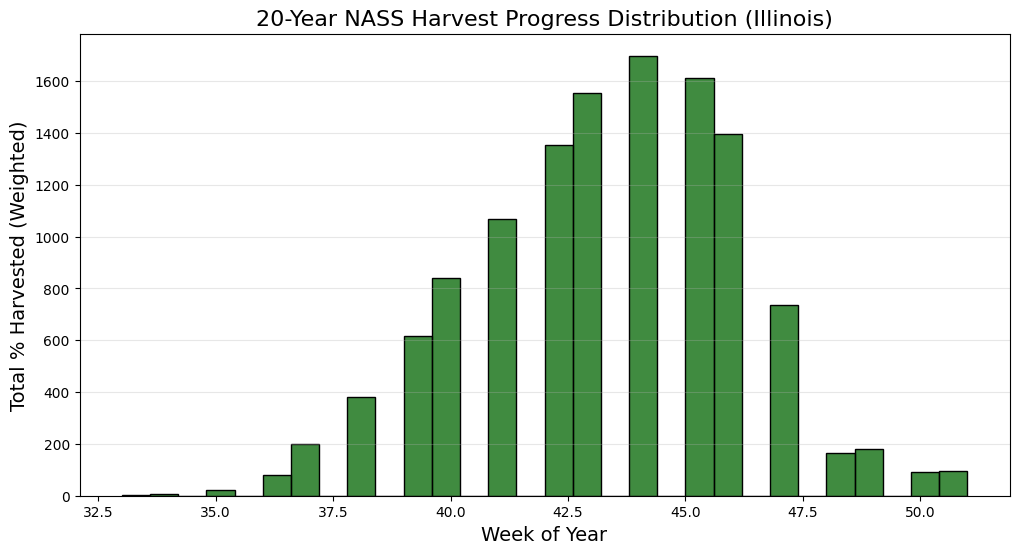

In [ ]:

# Load your cleaned NASS harvest data
df = df_harvested_clean.copy()   # or pd.read_csv("data/processed/nass_corn_harvest_weekly_clean.csv")

plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x="week",
    weights="pct_harvested",
    bins=30,
    kde=False,
    color="darkgreen",
    edgecolor="black"
)

plt.title("20-Year NASS Harvest Progress Distribution (Illinois)", fontsize=16)
plt.xlabel("Week of Year", fontsize=14)
plt.ylabel("Total % Harvested (Weighted)", fontsize=14)
plt.grid(axis="y", alpha=0.3)

plt.show()


In [228]:
median_start = int(harvest_windows_df["harvest_start_week"].median())
median_end = int(harvest_windows_df["harvest_end_week"].median())
late_buffer_weeks = 3

pd.DataFrame({
    "nass_start": [median_start],
    "nass_end": [median_end],
    "late_buffer_weeks": [late_buffer_weeks]
})


,nass_start,nass_end,late_buffer_weeks
0,36,44,3


In [241]:
weekly_master.columns

Index(['year', 'week', 'prcp_week_in', 'TMAX', 'TMIN', 'TAVG', 'AWND',
       'capacity_factor', 'rain_category', 'labor_hours', 'plant_start_week',
       'plant_end_week', 'harvest_start_week', 'harvest_end_week',
       'is_plant_window', 'is_harvest_window'],
      dtype='object')

In [240]:
fields.columns
# weekly_master.columns

Index(['field_id', 'crop_code', 'crop_name', 'acres', 'centroid_lat',
       'centroid_lon', 'state_fips', 'state_name', 'region'],
      dtype='object')

In [247]:
def plot_actual_2017_from_nass(weekly_master_path, fields):
    """
    Converts NASS statewide planting & harvest windows into a
    field-style distribution that is directly comparable to your MILP plot.
    """
    # Load data
    wm = weekly_master
    # fields = fields
    total_fields = fields.shape[0]   # e.g., 40 fields

    # Filter to 2017
    df = wm[wm["year"] == 2017].copy()

    # Pull window weeks
    plant_weeks = df[df["is_plant_window"] == 1]["week"].tolist()
    harvest_weeks = df[df["is_harvest_window"] == 1]["week"].tolist()

    # Expand each window week to match field count
    plant_field_style = []
    harvest_field_style = []

    # Distribute fields evenly across all valid weeks
    # (because actual NASS doesn't give per-field data)
    fields_per_week_plant = total_fields // len(plant_weeks)
    fields_per_week_harvest = total_fields // len(harvest_weeks)

    for w in plant_weeks:
        plant_field_style += [w] * fields_per_week_plant

    for w in harvest_weeks:
        harvest_field_style += [w] * fields_per_week_harvest

    # Plot
    plt.figure(figsize=(12,6))

    sns.histplot(
        plant_field_style,
        bins=range(10, 40),
        color="skyblue",
        alpha=0.7,
        label="Actual Planting (NASS window → fields)",
        kde=False
    )

    sns.histplot(
        harvest_field_style,
        bins=range(30, 53),
        color="salmon",
        alpha=0.7,
        label="Actual Harvesting (NASS window → fields)",
        kde=False
    )

    plt.xlabel("Week")
    plt.ylabel("Field Count")
    plt.title("Actual 2017 Planting & Harvesting Distribution (Field-Comparable)")
    plt.legend()
    plt.tight_layout()
    plt.show()


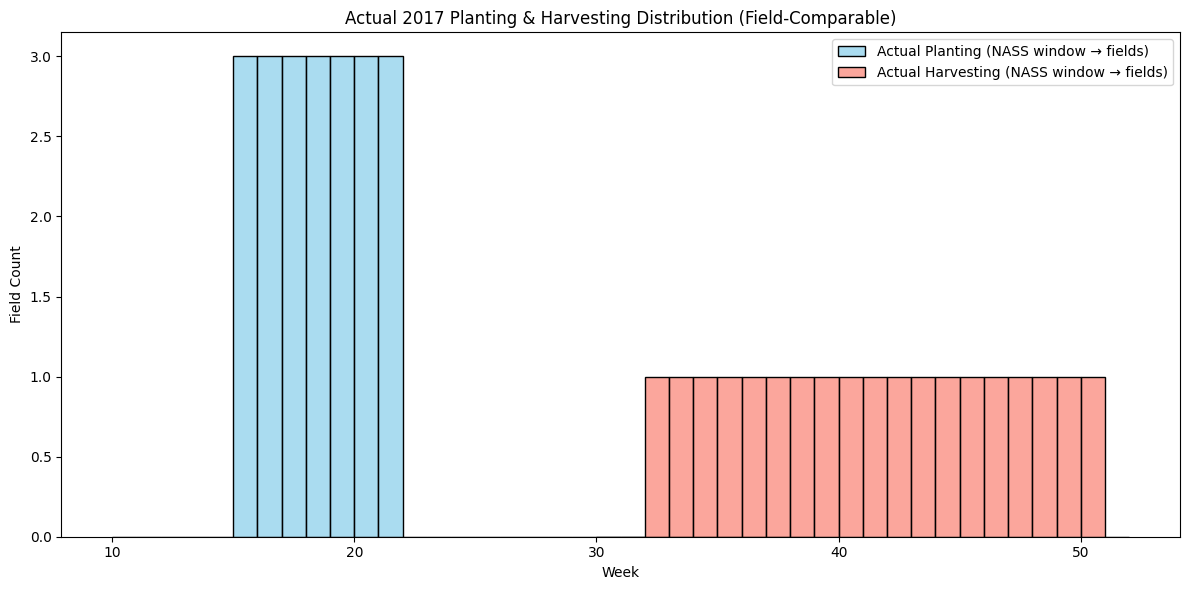

In [248]:
plot_actual_2017_from_nass(weekly_master,fields)

In [246]:
fields.shape[0]

25